# Predicte failures with labeled dataset

This notebook is built around Ignacio Vinuales code for Dealing with Class Imbalance.<br>
The original code can be found at https://www.kaggle.com/code/ignaciovinuales/dealing-with-class-imbalance-auc-93-f1-94-eda

Let's start with importing packages, load data and perform some data cleaning!

In [2]:
## Create a new virtual environment
!python3 -m venv venv
## Activate the virtual environment
!source venv/bin/activate

In [3]:
## Install the required packages
!pip install pandas==2.1.4 numpy==1.26.3 matplotlib==3.8.2 seaborn==0.12.2 plotly==5.22.0 scikit-learn==1.4.0 imblearn==0.0

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, precision_recall_curve
import pickle

# Hide warnings output
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['PYTHONWARNINGS']="ignore"

sns.set()

In [5]:
raw_data = pd.read_csv('../data/predictive_maintenance.csv')
df = raw_data.copy()
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [6]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

In [7]:
# Checking unique values for 'UDI' and 'Product ID'
print(f"{df['UDI'].nunique()} unique values for 'UDI'")
print(f"{df['Product ID'].nunique()} unique value for 'Pruduct ID'")

10000 unique values for 'UDI'
10000 unique value for 'Pruduct ID'


In [8]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [9]:
sensorCols = [
    "Air temperature [K]",
    "Process temperature [K]",
    "Rotational speed [rpm]",
    "Torque [Nm]",
    "Tool wear [min]"
]

In [10]:
# Taking a look at 'Failure Type' variable
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [11]:
df['Target'].value_counts(normalize=True)

Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64

In [12]:
# Rechecking for missing values
df.isna().sum()

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [13]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

'Type' assumes three possible values. Later on they will be hot or ordinal encoded.

In [14]:
# Taking a look at the data types
df.dtypes

Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

There are two target variables: 'Target' and 'Failure Type'.

In [15]:
# Checking types of failure
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

In [16]:
# Create a failure only dataset (target = 1)
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Failure Type
Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: count, dtype: int64

In [17]:
# Check if there is any 'No Failure' in this dataset
df_failure[df_failure['Failure Type'] == 'No Failure']

Type  Air temperature [K]  Process temperature [K]  \
1437    H                298.8                    309.9   
2749    M                299.7                    309.2   
4044    M                301.9                    310.9   
4684    M                303.6                    311.8   
5536    M                302.3                    311.8   
5941    L                300.6                    310.7   
6478    L                300.5                    309.8   
8506    L                298.4                    309.6   
9015    L                297.2                    308.1   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
1437                    1439         45.2               40       1   
2749                    1685         28.9              179       1   
4044                    1419         47.7               20       1   
4684                    1421         44.8              101       1   
5536                    1363         54.0              119       1   
5941                    1438         48.5               78       1   
6478                    1663         29.1              145       1   
8506                    1710         27.3              163       1   
9015                    1431         49.7              210       1   

     Failure Type  
1437   No Failure  
2749   No Failure  
4044   No Failure  
4684   No Failure  
5536   No Failure  
5941   No Failure  
6478   No Failure  
8506   No Failure  
9015   No Failure

In [18]:
# Removing those rows
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
df.drop(index_possible_failure, axis=0, inplace=True)

In [19]:
df_failure = df[df['Target'] == 0]
df_failure['Failure Type'].value_counts()

Failure Type
No Failure         9643
Random Failures      18
Name: count, dtype: int64

In [20]:
print(set(df["Failure Type"].values.tolist()))

{'No Failure', 'Overstrain Failure', 'Heat Dissipation Failure', 'Random Failures', 'Tool Wear Failure', 'Power Failure'}


In [21]:
# Checking for Random Failures in the dataset
df_failure[df_failure['Failure Type'] == 'Random Failures']

Type  Air temperature [K]  Process temperature [K]  \
1221    M                297.0                    308.3   
1302    L                298.6                    309.8   
1748    H                298.4                    307.7   
2072    L                299.6                    309.5   
2559    L                299.3                    309.0   
3065    M                300.1                    309.2   
3452    H                301.6                    310.5   
5471    L                302.7                    312.3   
5489    L                302.6                    312.1   
5495    H                302.9                    312.5   
5509    L                302.8                    312.2   
5553    L                302.5                    311.9   
5639    L                302.6                    312.1   
6091    L                300.9                    310.7   
6913    L                300.8                    311.2   
6960    L                300.7                    311.0   
7488    L                300.3                    311.7   
7868    H                300.4                    311.9   

      Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  \
1221                    1399         46.4              132       0   
1302                    1505         45.7              144       0   
1748                    1626         31.1              166       0   
2072                    1570         35.5              189       0   
2559                    1447         50.4              140       0   
3065                    1687         27.7               95       0   
3452                    1602         32.3                2       0   
5471                    1346         61.2              170       0   
5489                    1499         35.0              215       0   
5495                    1357         55.0               12       0   
5509                    1509         36.5               52       0   
5553                    1306         59.7              172       0   
5639                    1668         28.7              180       0   
6091                    1412         57.5               16       0   
6913                    1481         38.5              181       0   
6960                    1413         52.0               91       0   
7488                    1545         43.5              160       0   
7868                    1438         46.7               41       0   

         Failure Type  
1221  Random Failures  
1302  Random Failures  
1748  Random Failures  
2072  Random Failures  
2559  Random Failures  
3065  Random Failures  
3452  Random Failures  
5471  Random Failures  
5489  Random Failures  
5495  Random Failures  
5509  Random Failures  
5553  Random Failures  
5639  Random Failures  
6091  Random Failures  
6913  Random Failures  
6960  Random Failures  
7488  Random Failures  
7868  Random Failures

In [22]:
# Remove these as they are not certain machinery failures
index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
try:
    df.drop(index_possible_failure, axis=0, inplace=True)
except Exception as e:
    print(f"Could not drop index {index_possible_failure} because {e}")

In [23]:
df.shape[0]

9973

In [24]:
# Reset index
df.reset_index(inplace=True, drop=True)

# Explanatory Data Analysis (EDA)
Let's explore the data and see if we can find some patterns.

## Correlation

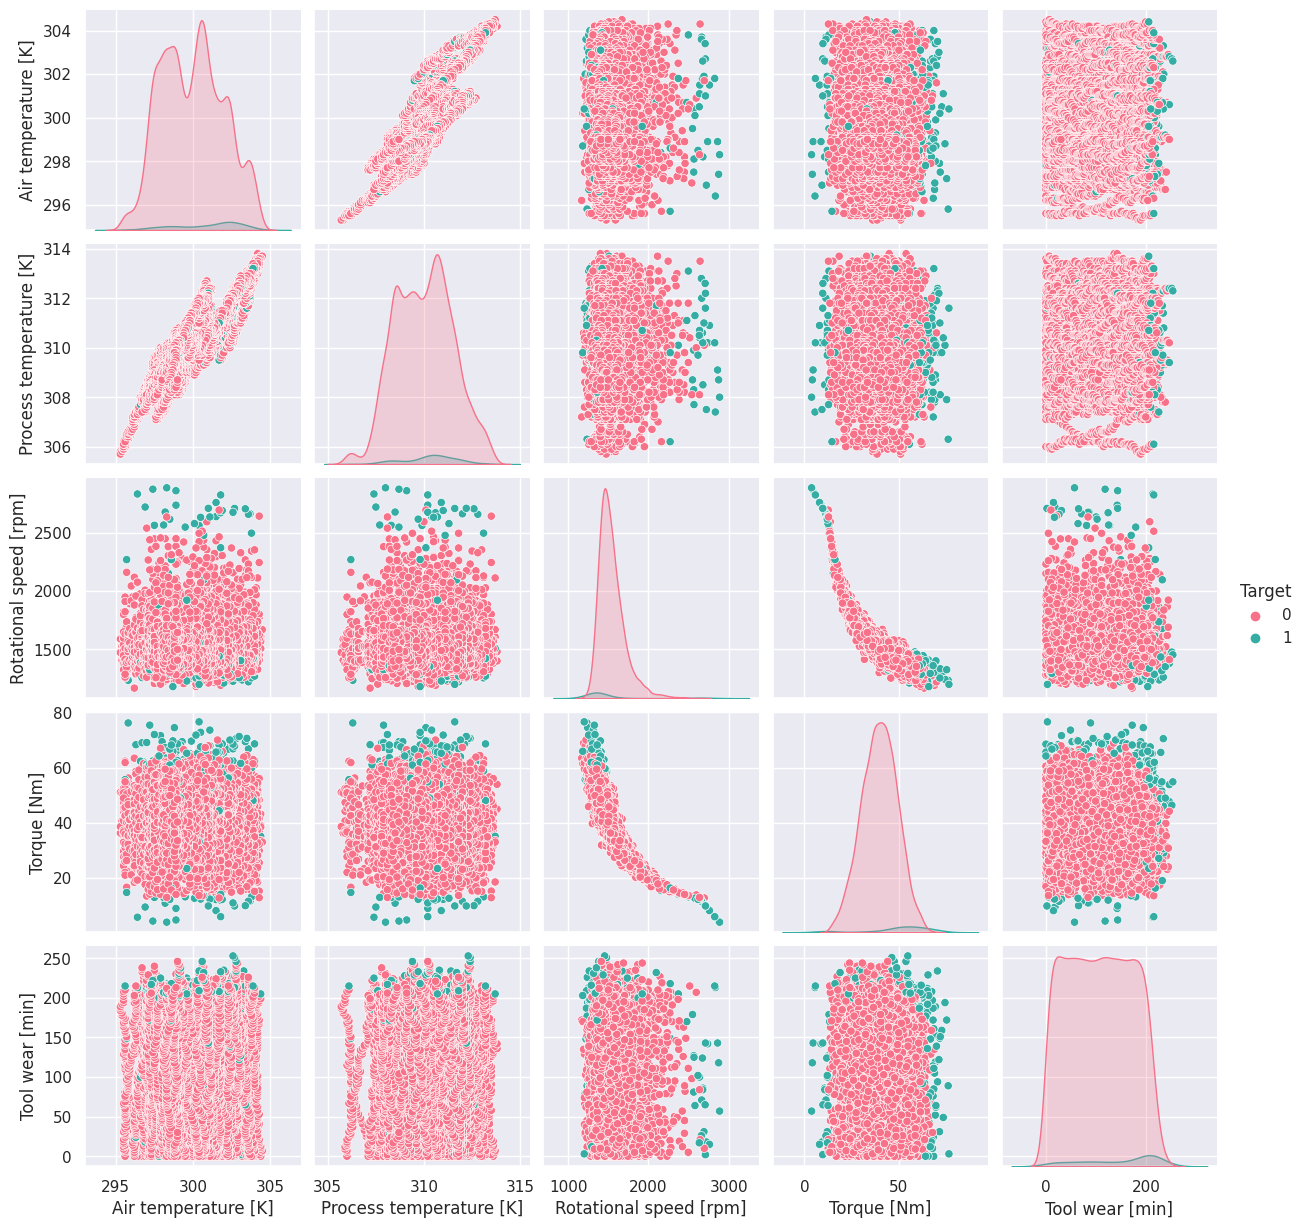

In [25]:
sns.pairplot(df, hue='Target', palette='husl')

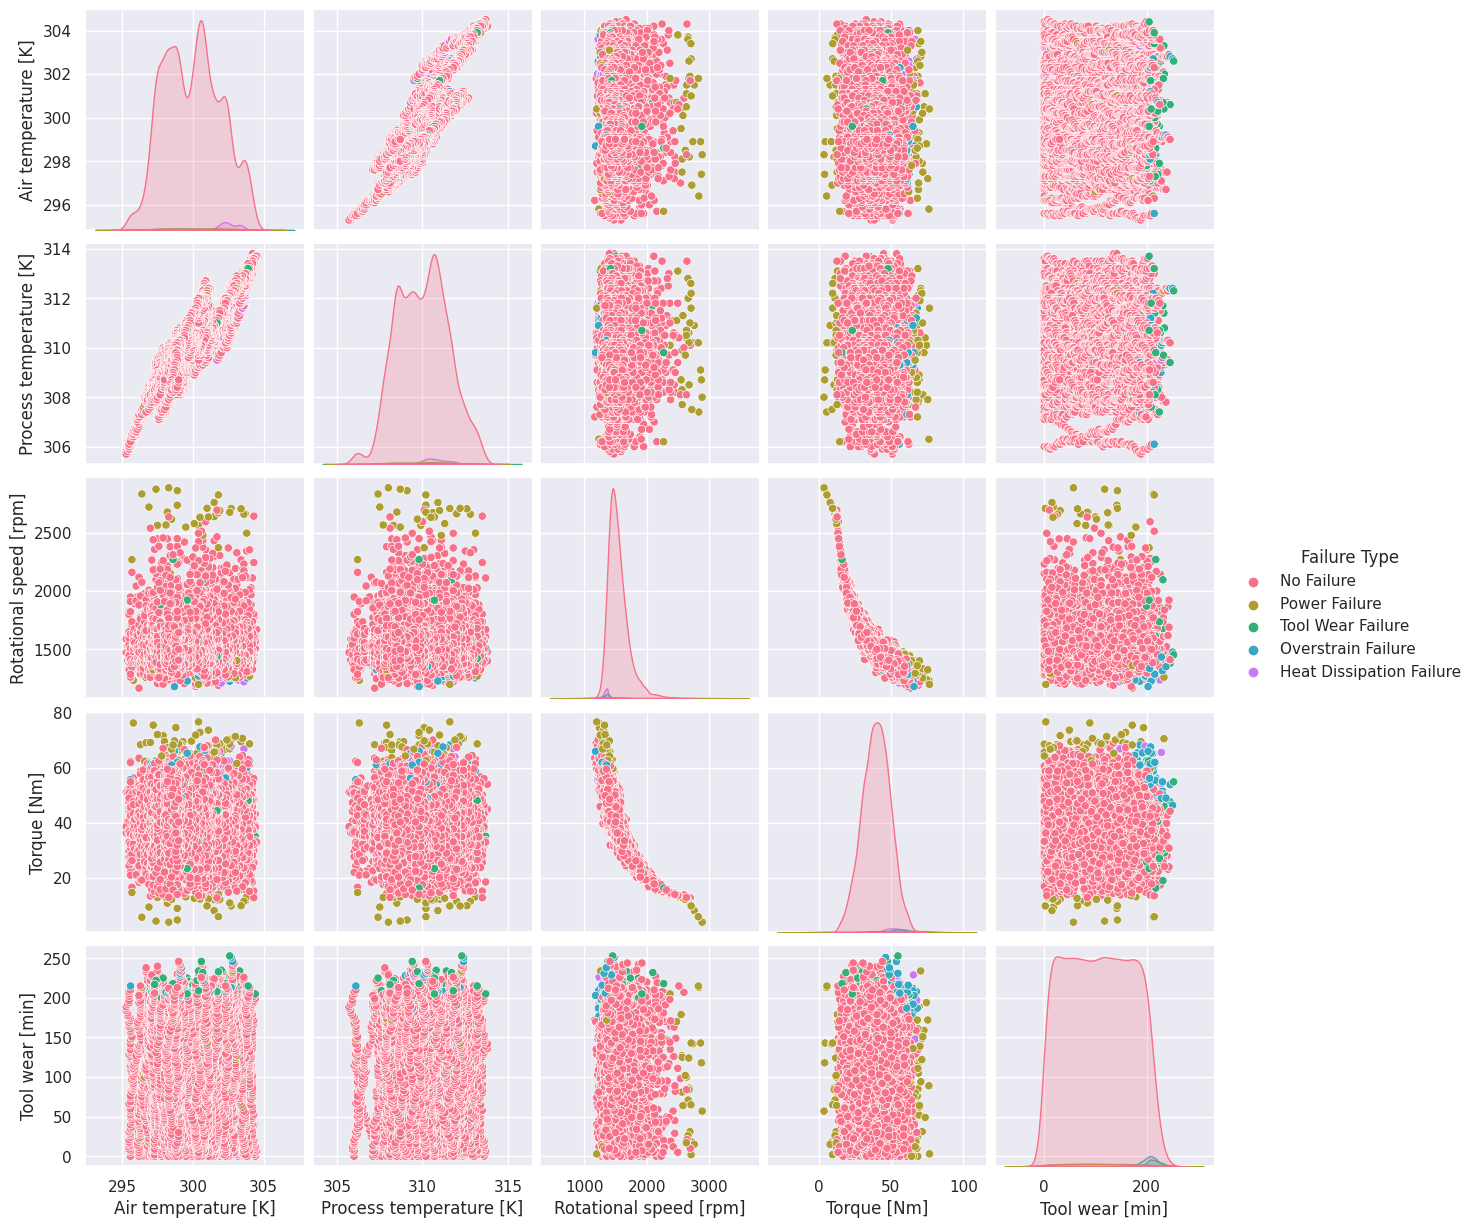

In [26]:
pairPlotDf = df.drop(['Target'], axis=1)
sns.pairplot(pairPlotDf, hue='Failure Type', palette='husl')

**Insights:** 
* Torque and rotational speed are highly correlated.
* Process temperature and air temperature are also highly correlated.
* We immediately see that failures occur for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

Let's plot a violin chart to see how torque and rotational speed behave:

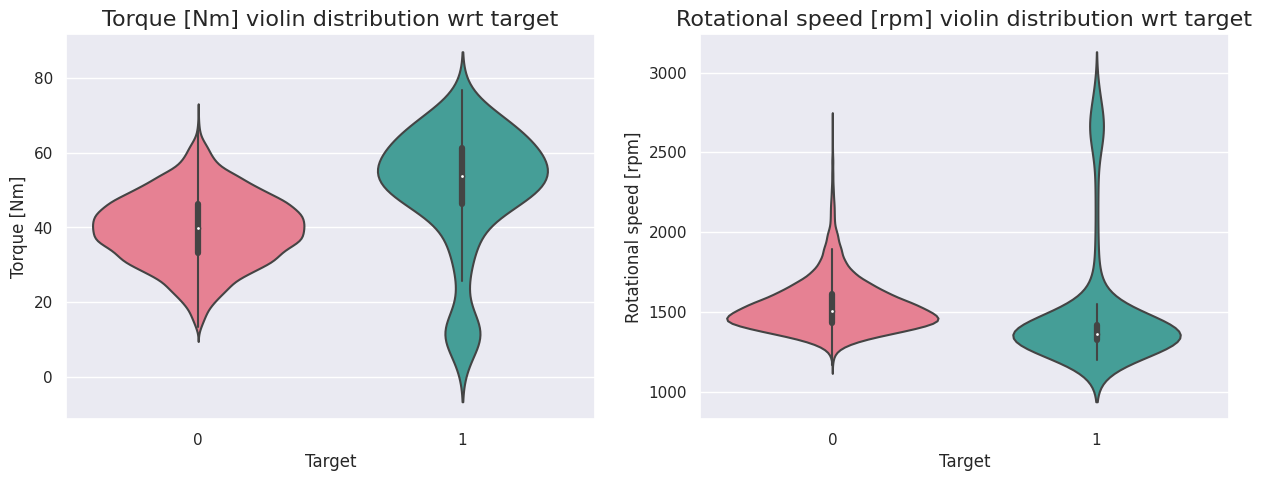

In [27]:
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

fig, axes = plt.subplots(1, 2, figsize=[15,5])
axes = axes.flatten()
j=0

for i in ['Torque [Nm]', 'Rotational speed [rpm]']:
    sns.violinplot(data=df, x='Target', y=i, ax=axes[j], palette='husl')
    axes[j].set_title(i + ' violin distribution wrt target', )
    j += 1

**Insight:** Regarding torque and rotational speed, it can be seen again that most failures are triggered for much lower or much higher values than the mean when not failing.

## Percentage of failure

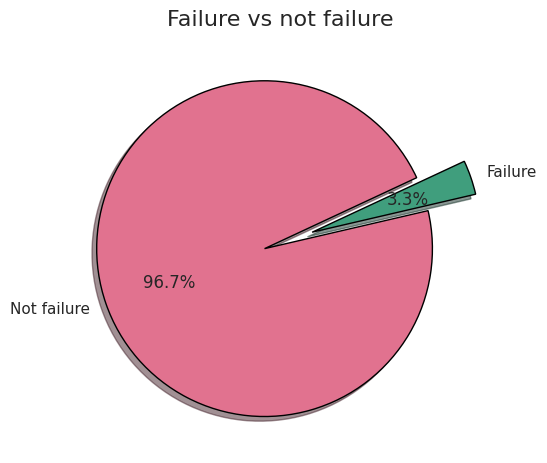

In [28]:
colors = ['#E1728F', '#409E7D'] 
plt.pie(df['Target'].value_counts(),  explode=[0.1, 0.2], labels=['Not failure', 'Failure'],
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
        colors=colors)
plt.title('Failure vs not failure')
plt.tight_layout()
plt.show()

## Correlation heatmap

In [29]:
df.head()

Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure

In [30]:
dfTest = pd.get_dummies(df, columns=['Type', 'Failure Type'])
dfTest.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target  Type_H  Type_L  Type_M  \
0         42.8                0       0   False   False    True   
1         46.3                3       0   False    True   False   
2         49.4                5       0   False    True   False   
3         39.5                7       0   False    True   False   
4         40.0                9       0   False    True   False   

   Failure Type_Heat Dissipation Failure  Failure Type_No Failure  \
0                                  False                     True   
1                                  False                     True   
2                                  False                     True   
3                                  False                     True   
4                                  False                     True   

   Failure Type_Overstrain Failure  Failure Type_Power Failure  \
0                            False                       False   
1                            False                       False   
2                            False                       False   
3                            False                       False   
4                            False                       False   

   Failure Type_Tool Wear Failure  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False

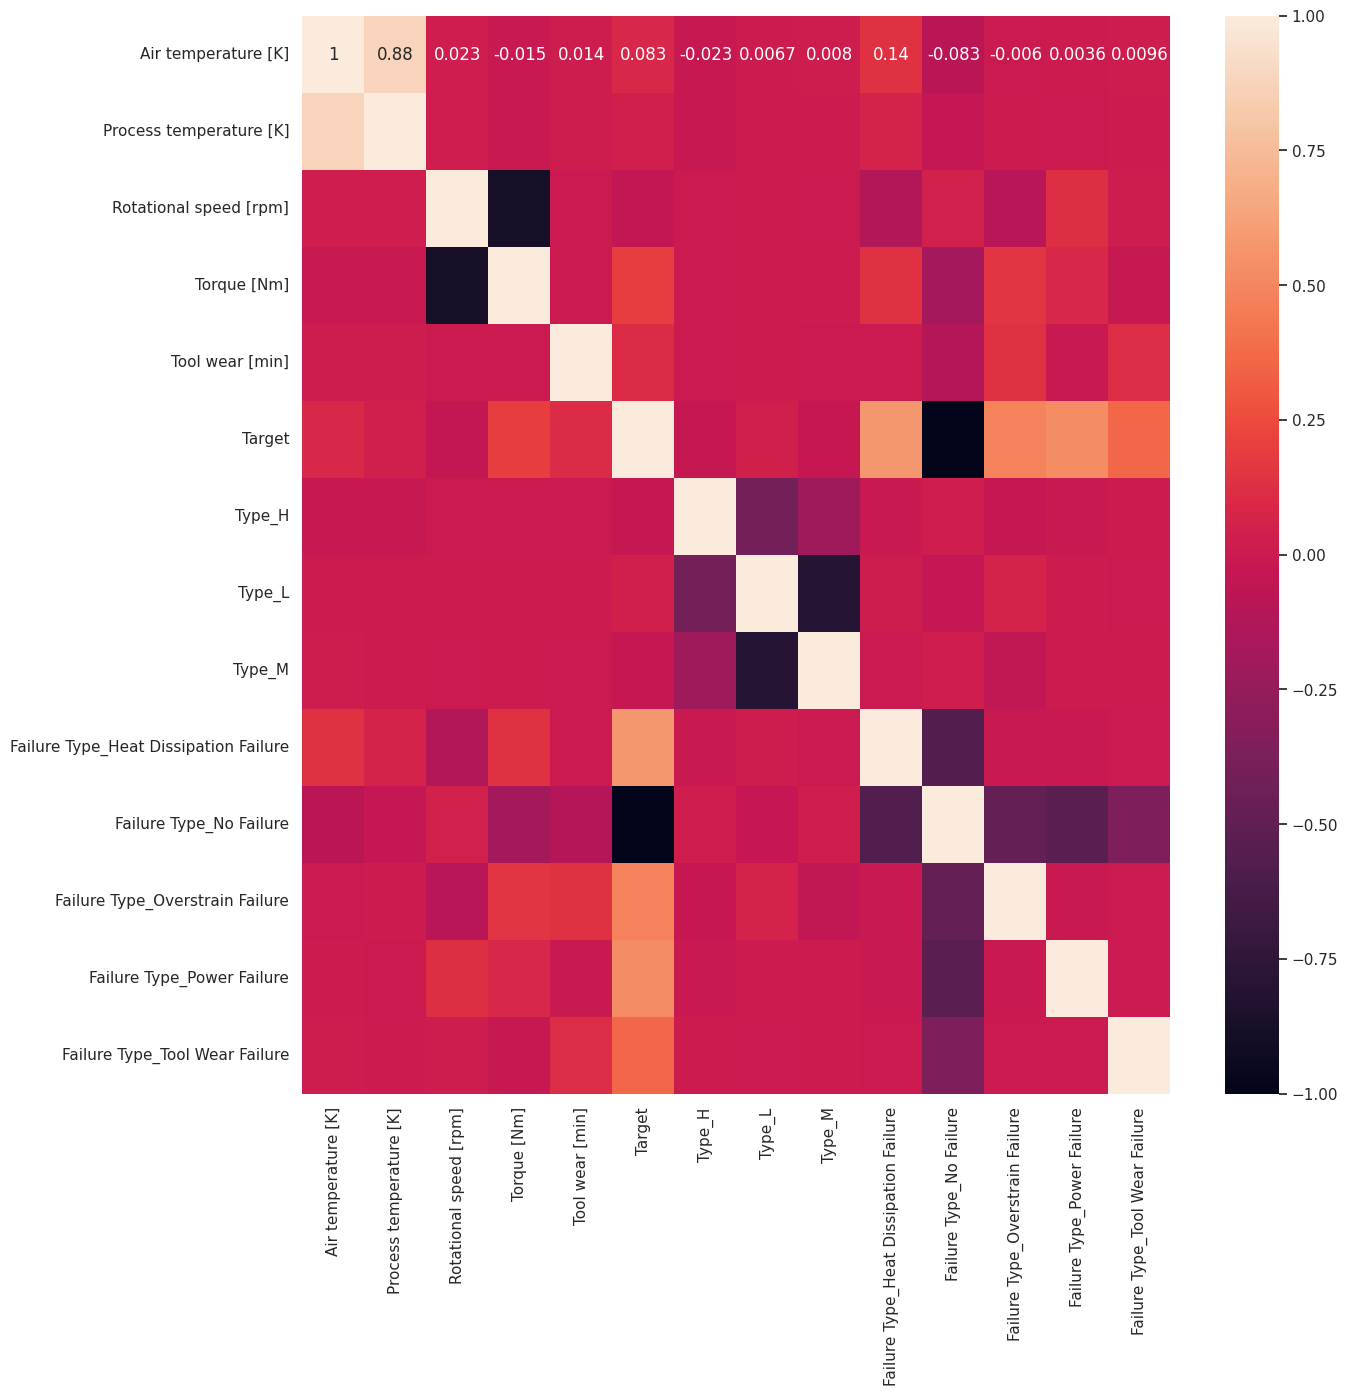

In [31]:
# Number of variables (columns) for the heatmap
num_vars = len(dfTest.columns)
# Set the size of the plot dynamically
scalingN = 1
fig_size = max(8, num_vars * scalingN)
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(dfTest.corr(), annot=True)
plt.show()

As mentioned before, there is high correlation between process temperature and air temperature, and between rotational speed and torque.


## Product Types

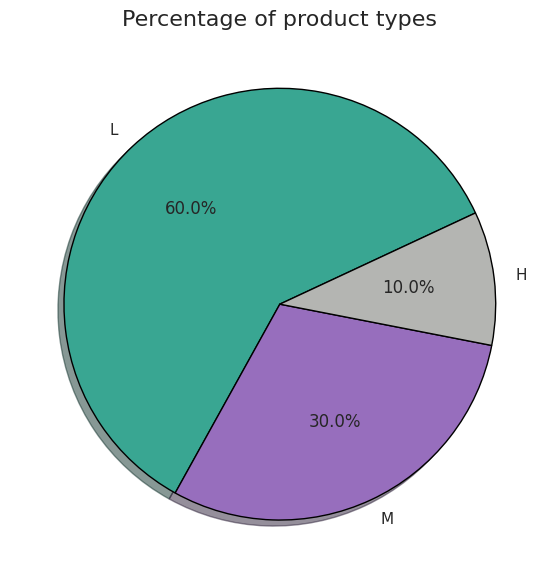

In [32]:
plt.rcParams["figure.figsize"] = (6,6)
colors = ['#39A692', '#976EBD', '#B4B5B2']
plt.pie(df['Type'].value_counts(), labels=['L', 'M', 'H'], colors=colors,
    autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)

plt.title('Percentage of product types')
plt.tight_layout()

### Percentage of failure wrt product type

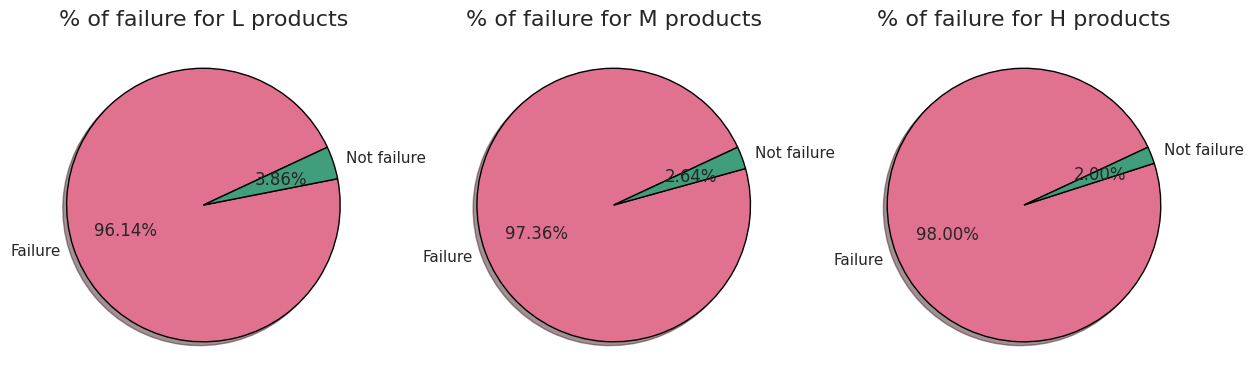

In [33]:
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Failure', 'Not failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

**Insight:** L products have a higher ratio of failure compared to the other product types. Moreover, M tends to fail more than H products.

### Percentage of failure types

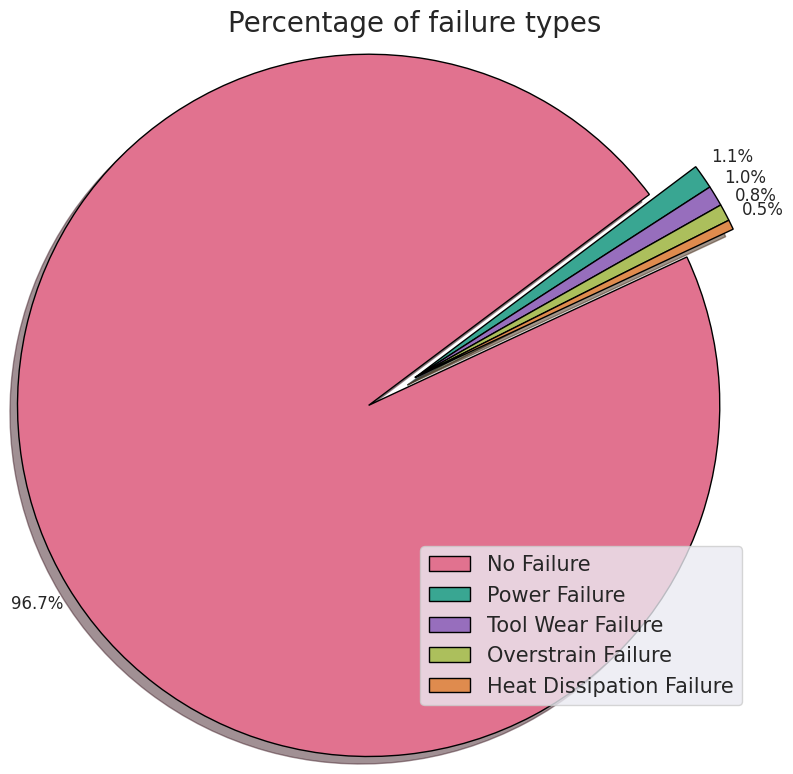

In [34]:
columns_failure_type = df['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (8,8)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(df['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

### Exploring features for each type of failure

Text(0.5, 1.0, 'Excluding class no failure')

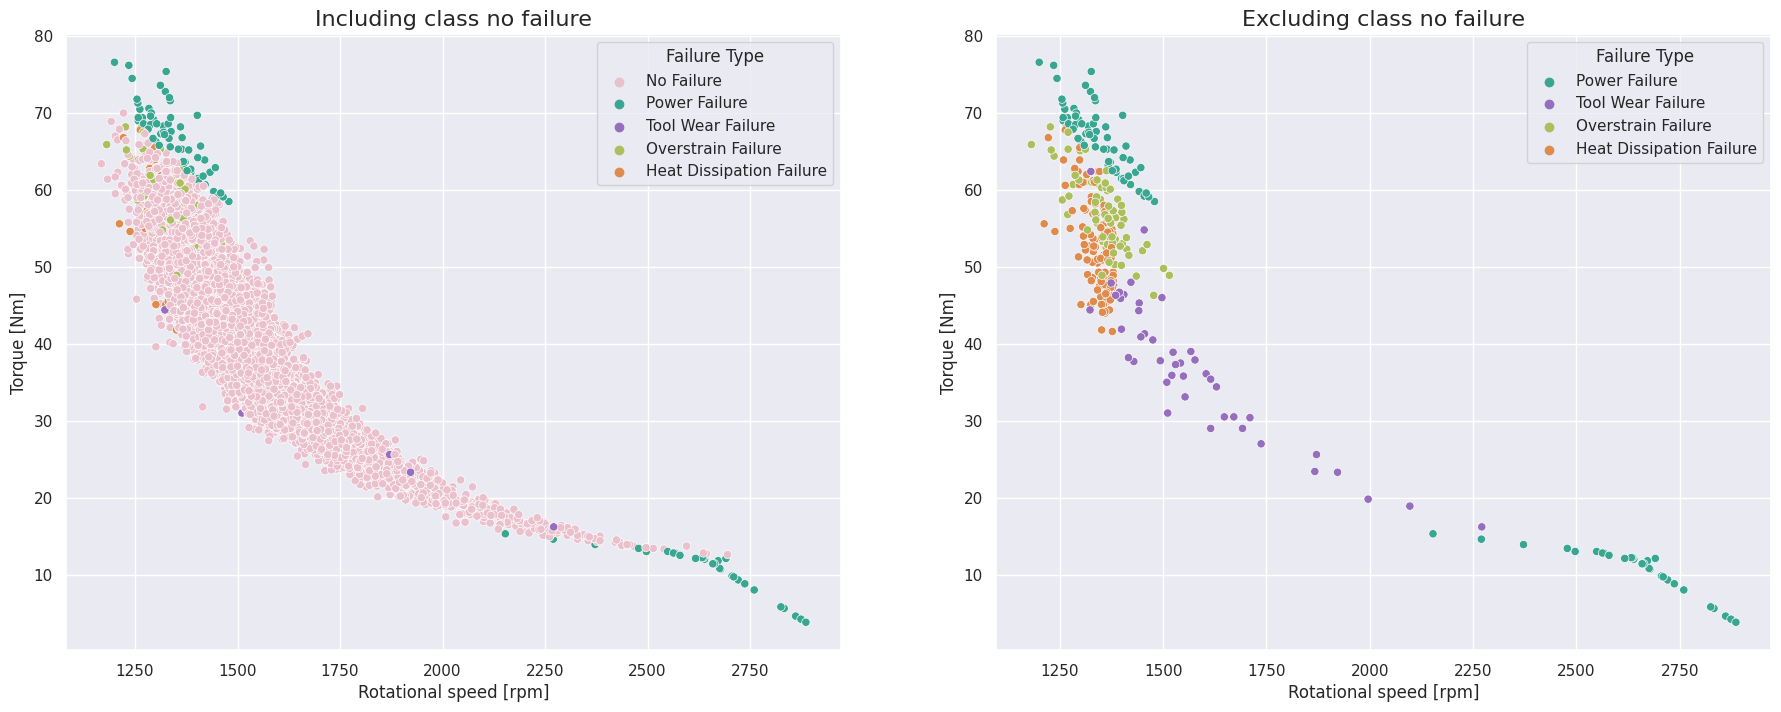

In [35]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=df, x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=df[df['Target'] == 1], x='Rotational speed [rpm]', y='Torque [Nm]', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

**Some insights:**
* Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other others, above and below these thresholds only power failures occur. 
* Between torques 16Nm and 41Nm all failures are tool wear. 
* Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm approximately.
* For heat dissipation failures, the torque range is smaller and the rotational speed range is bigger compared to overstrain failures.



## Distribution 

----- SKEWNESS ------------
Air temperature [K] skewness = 0.12
Process temperature [K] skewness = 0.02
Rotational speed [rpm] skewness = 1.99
Torque [Nm] skewness = -0.01
Tool wear [min] skewness = 0.03
---------------------------


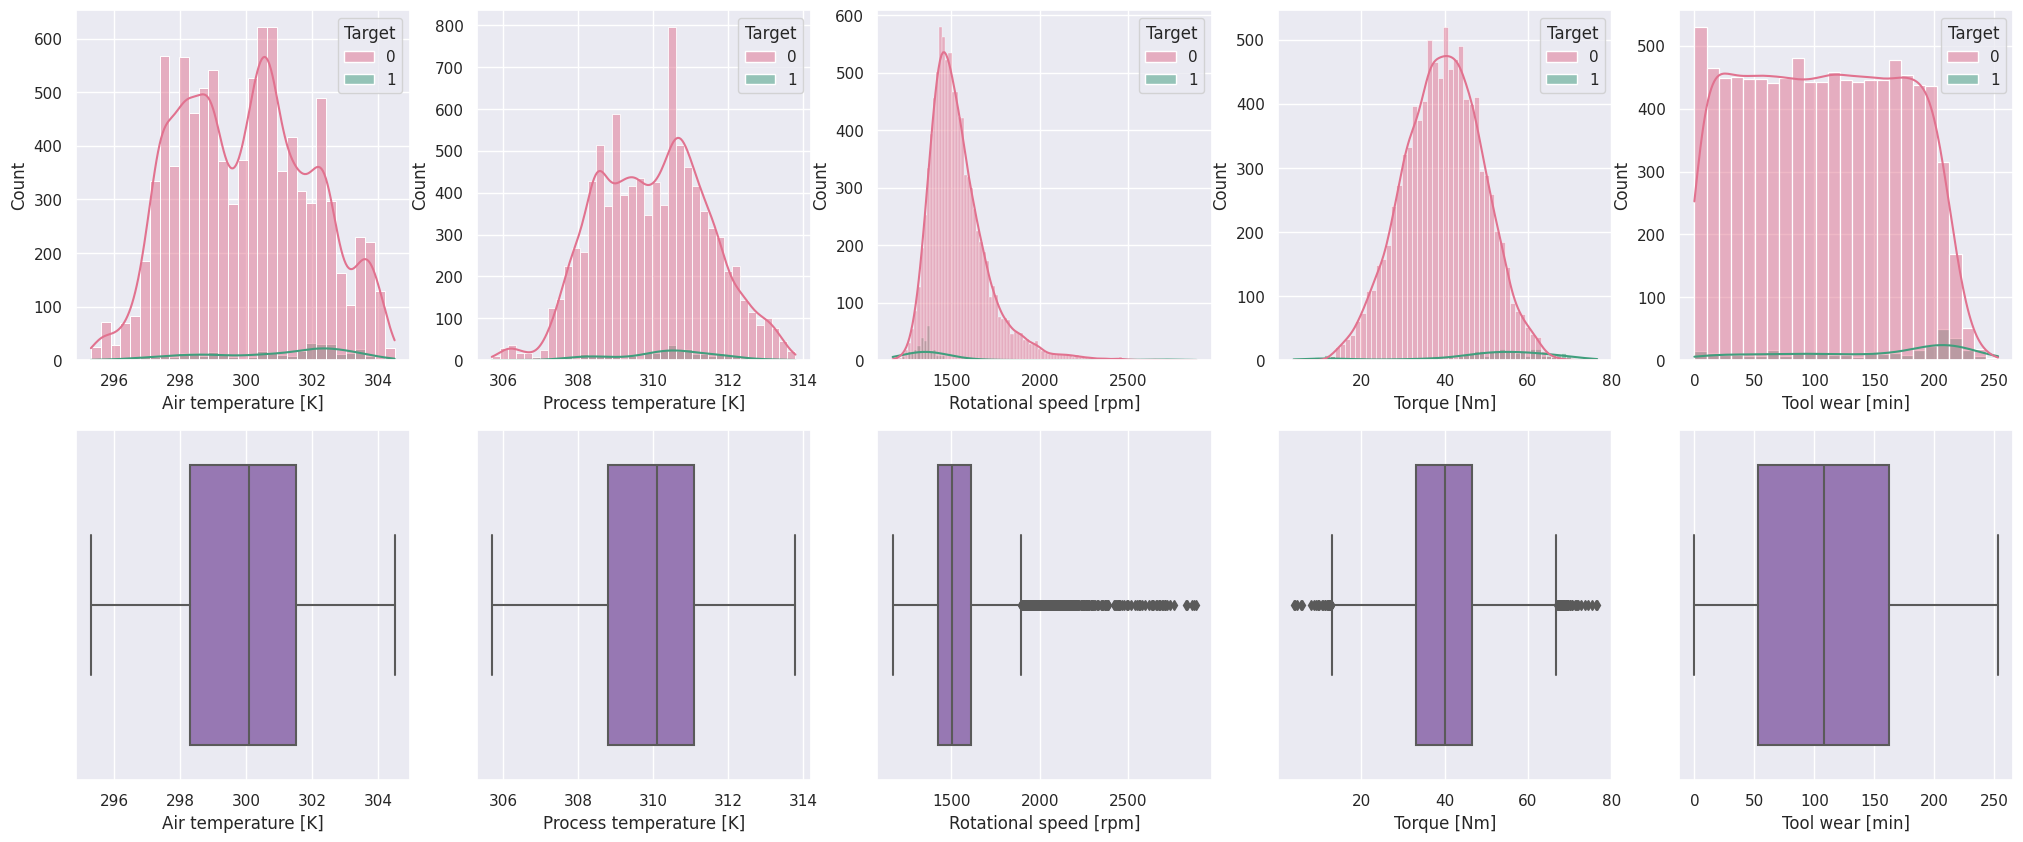

In [36]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in sensorCols: #['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']:
    sns.histplot(data=df, x=i, kde=True, ax=axes[0,j], hue='Target', palette=colors)
    sns.boxplot(data=df, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1
    print('{} skewness = {}'.format(i, round(df[i].skew(), 2)))
print('---------------------------')

* Rotational speed is positively skewed.
* From the boxplots we can see that 'Rotational speed' and 'Torque' have outliers.

Let's check those potential 'outliers' by analyzing the boxplots:


In [37]:
# Function to calculate the maximum and minumum value from the boxplot
def maximum_box(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    maximum = Q3 + 1.5*IQR
    minimum = Q1 - 1.5*IQR
    return maximum, minimum

for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    max_rotational_speed, min_rotational_speed = maximum_box(df_product_type['Rotational speed [rpm]'])
    max_torque, min_torque = maximum_box(df_product_type['Torque [Nm]'])
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


**Insight:** The operational range for torque and rotational speed are similar for all product types.

Values above the maximum and below the minimum might be outliers, but not necessarily. 

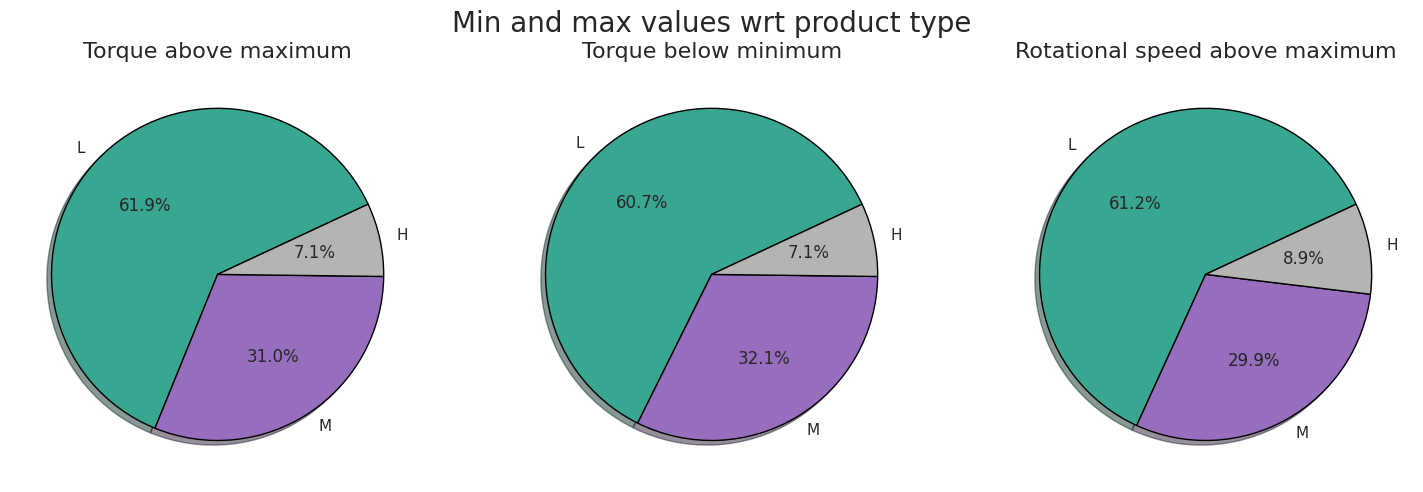

In [38]:
max_rotational_speed, min_rotational_speed = maximum_box(df['Rotational speed [rpm]'])
max_torque, min_torque = maximum_box(df['Torque [Nm]'])

max_torque_values = df[df['Torque [Nm]'] >= max_torque]['Type'].value_counts()  # Torque values above the boxplot maximum
min_torque_values = df[df['Torque [Nm]'] <= min_torque]['Type'].value_counts()  # Torque values below the boxplot minimum
max_rotational_speed_values = df[df['Rotational speed [rpm]'] >= max_rotational_speed]['Type'].value_counts()  # Rotational spede values above the boxplot maximum

fig, axes = plt.subplots(1,3, figsize=[15,5])
fig.suptitle('Min and max values wrt product type', fontsize=20)
plt.rcParams['axes.titlesize'] = 16
axes.flatten()
j=0
colors = ['#39A692', '#976EBD', '#B4B5B2']

for i in [max_torque_values, min_torque_values, max_rotational_speed_values]:
    axes[j].pie(i, labels=['L', 'M', 'H'], colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)
    j+=1

axes[0].set_title('Torque above maximum')
axes[1].set_title('Torque below minimum')
axes[2].set_title('Rotational speed above maximum')
plt.tight_layout()

**Insight:** The values above the maximum and below the minimum are not highly correlated with the product type. The proportion of the pies is similar to the 60-30-10 proportion of the entire dataset.

However, there are proportionally slightly more values for L products and less for H across the three scenarios.

In [39]:
total_max_min_values = max_torque_values.sum() + min_torque_values.sum() + max_rotational_speed_values.sum()  # Total of instance under and above the minimum and maximum threshold from the boxplot, respectively.
ratio = total_max_min_values/df.shape[0]  # Percetange of these values with respect to the entire dataset
print('Percentage of values under and above the minimum and maximum threshold from the boxplot: {}'.format(ratio))

Percentage of values under and above the minimum and maximum threshold from the boxplot: 0.048932116715130855


**Insight:** 4.87% of the instances could be considered as ouliers using the boxplot method.

## Data Preprocessing

In [40]:
columns_failure_type = df['Failure Type'].unique().tolist()

## Ordinal Encoding

In [41]:
# Pass on the categorical values
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
new_dat
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

## Scaling data

Since 'Rotational spede' and 'Torque' have some outliers, I am going to use RobustScaler:

In [42]:
df_scaled = df.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed [rpm]', 'Torque [Nm]']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

Air temperature [K]  Process temperature [K]  Tool wear [min]  Target  \
0                298.1                    308.6                0       0   
1                298.2                    308.7                3       0   
2                298.1                    308.5                5       0   
3                298.2                    308.6                7       0   
4                298.2                    308.7                9       0   

   Type  Failure Type  Rotational speed [rpm]  Torque [Nm]  
0   1.0           0.0                0.253968     0.200000  
1   0.0           0.0               -0.502646     0.459259  
2   0.0           0.0               -0.026455     0.688889  
3   0.0           0.0               -0.370370    -0.044444  
4   0.0           0.0               -0.502646    -0.007407

The rest of the features will be scaled with MinMax scaling:

In [43]:
columns = ['Air temperature [K]', 'Process temperature [K]', 'Tool wear [min]']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled.head()

Target  Type  Failure Type  Rotational speed [rpm]  Torque [Nm]  \
0       0   1.0           0.0                0.253968     0.200000   
1       0   0.0           0.0               -0.502646     0.459259   
2       0   0.0           0.0               -0.026455     0.688889   
3       0   0.0           0.0               -0.370370    -0.044444   
4       0   0.0           0.0               -0.502646    -0.007407   

   Air temperature [K]  Process temperature [K]  Tool wear [min]  
0             0.304348                 0.358025         0.000000  
1             0.315217                 0.370370         0.011858  
2             0.304348                 0.345679         0.019763  
3             0.315217                 0.358025         0.027668  
4             0.315217                 0.370370         0.035573

## Modeling with 'Target' variable

As the dataset is unbalanced, I am going to used macro f1 score and ROC AUC score to assess model performance.

First, let's build a model with 'Target'. Hence, we need to remove the other target 'Failure Type' to avoid data leakage.

### Stratified Split

In [44]:
X = df_scaled.drop(['Target', 'Failure Type'], axis=1)
y = df_scaled['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
Target
0    0.966911
1    0.033089
Name: proportion, dtype: float64
Target proportion in y_train dataset:
Target
0    0.966974
1    0.033026
Name: proportion, dtype: float64
Target proportion in y_test dataset:
Target
0    0.96672
1    0.03328
Name: proportion, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

## Balanced Models

Let's train some base models to check how they perform.

In [45]:
def plotConfusionMatrix(cm, title, columns):
    
    dfToPlot = pd.DataFrame(cm, columns=columns, index=columns)
    
    # Start plotting
    fig, ax = plt.subplots(figsize=(6, 4))  # Set the size of the figure

    # Create a heatmap using matshow
    cax = ax.matshow(cm, cmap='bwr', alpha=0.7)

    # Add color bar for reference
    cbar = plt.colorbar(cax)
    cbar.ax.tick_params(labelsize=6)  # Set font size for the color bar tick labels

    # Set ticks positions
    ax.set_xticks(np.arange(len(dfToPlot.columns)))
    ax.set_yticks(np.arange(len(dfToPlot.index)))

    # Label the ticks
    ax.set_xticklabels(dfToPlot.columns, fontsize=9)
    ax.set_yticklabels(dfToPlot.index, fontsize=9)

    # Rotate the tick labels for better visibility if necessary
    plt.xticks(rotation=45)

    # Adding annotations/text inside the heatmap cells
    for (i, j), val in np.ndenumerate(dfToPlot):
        ax.text(j, i, f'{val}', ha='center', va='center', color='yellow', fontsize=15)

    # Title and labels
    plt.title(title, fontsize=9)
    plt.ylabel('Actual label', fontsize=9)
    plt.xlabel('Predicted label', fontsize=9)

    # Show the plot
    plt.show()

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
Cross val roc auc test data: 0.9783
Cross val macro f1 score test data: 0.6154
Cross val macro precision score test data: 0.6063
Cross val macro recall score test data: 0.8646



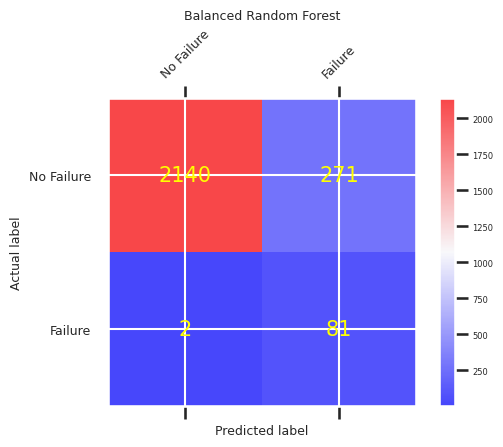

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
Cross val roc auc test data: 0.9733
Cross val macro f1 score test data: 0.674
Cross val macro precision score test data: 0.6324
Cross val macro recall score test data: 0.8621



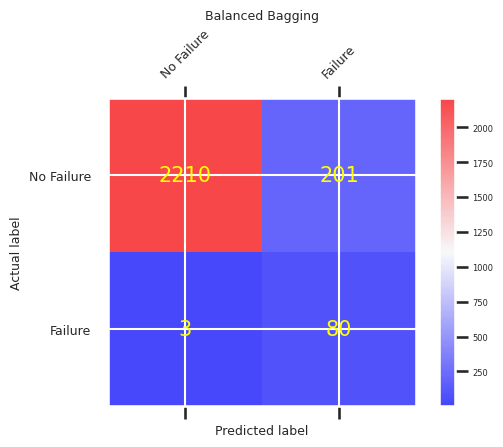

Fitting RUSBoostClassifier(random_state=42)
Cross val roc auc test data: 0.8757
Cross val macro f1 score test data: 0.5977
Cross val macro precision score test data: 0.6046
Cross val macro recall score test data: 0.7177



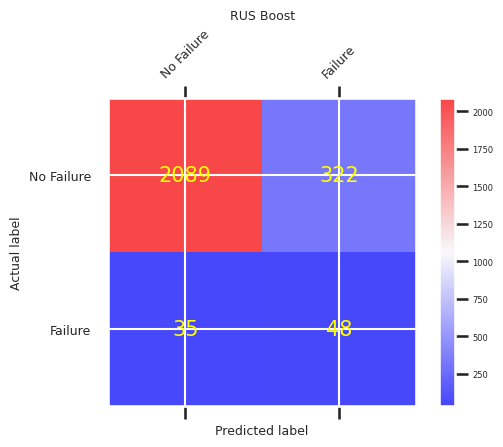

Fitting EasyEnsembleClassifier(random_state=42)
Cross val roc auc test data: 0.964
Cross val macro f1 score test data: 0.6216
Cross val macro precision score test data: 0.6037
Cross val macro recall score test data: 0.8341



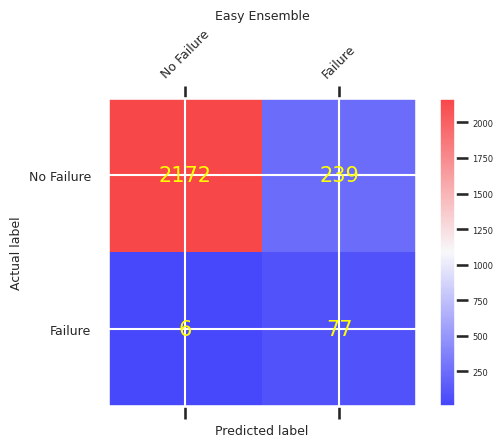

f1  roc_auc
BalancedBaggingClassifier       0.6740   0.9733
EasyEnsembleClassifier          0.6216   0.9640
BalancedRandomForestClassifier  0.6154   0.9783
RUSBoostClassifier              0.5977   0.8757

In [46]:

brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

j=0

results_df = pd.DataFrame()
titles = [
    'Balanced Random Forest',
    'Balanced Bagging',
    'RUS Boost',
    'Easy Ensemble'
]
for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    # Cross validation metrics test data
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
    y_pred = model.predict(X_test)
    scoring = ["f1_macro", "precision_macro", "recall_macro"]
    cross_val_scores = cross_validate(model, X, y, scoring=scoring)
    roc_auc_test_cv = round(cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="roc_auc").mean(),4)
    f1_test_cv = round(cross_val_scores["test_f1_macro"].mean(),4)
    precision_test_cv = round(cross_val_scores["test_precision_macro"].mean(),4)
    recall_test_cv = round(cross_val_scores["test_recall_macro"].mean(),4)
    
    # Summary table
    score_df = pd.DataFrame({
                     'f1': round(cross_val_scores["test_f1_macro"].mean(),4),
                     'roc_auc': roc_auc_test_cv},
                     index=[str(model).split('(')[0]])

    results_df = pd.concat([results_df, score_df])

    # Print metrics
    print(f'Cross val roc auc test data: {roc_auc_test_cv}')
    print(f'Cross val macro f1 score test data: {round(cross_val_scores["test_f1_macro"].mean(),4)}')
    print(f'Cross val macro precision score test data: {round(cross_val_scores["test_precision_macro"].mean(),4)}')
    print(f'Cross val macro recall score test data: {round(cross_val_scores["test_recall_macro"].mean(),4)}')
    print()
    
    # Confusion matrix test data
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    plotConfusionMatrix(cm,titles[j],['No Failure', 'Failure'])
    j += 1

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

All results are using cross validation:
- **Balanced Bagging is the best overall model**, with highest f1 score and second highest roc auc.
- Balanced Random Forest has a slightly highest roc auc than Balanced Bagging, but its f1 score is lower.
- Easy Ensemble has a high roc auc thant Balance Bagging, but very low f1 score.

## Over and undersampling with Random Forest and Bagging classifiers (Random Search)

Now, let's try using different sampling techniques with random forest and balanced bagging to see if we achieve better performance than the balanced models:

In [47]:
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')
bbc = BaggingClassifier(random_state=42, n_jobs=-1)

OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, n_jobs=-1)
OverSamp_3 = BorderlineSMOTE(random_state=42, n_jobs=-1)
OverSamp_4 = ClusterCentroids(random_state=42)
OverSamp_5 = TomekLinks(n_jobs=-1)
OverSamp_6 = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

OverSamp_list = [OverSamp_1, OverSamp_2, OverSamp_3, OverSamp_4, OverSamp_5, OverSamp_6]

for model in [RdFo, bbc]:
    if model == RdFo:
        grid_param = {'n_estimators': np.arange(10, 160,10),
                       'max_depth': np.arange(10, 110, 10),
                       'min_samples_split': [2, 5, 10]}
        
    else:
        grid_param = {'n_estimators': np.arange(10, 160,10)}
                      
    for samp in OverSamp_list:
        X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)

        random_search = RandomizedSearchCV(model, grid_param, cv=3, n_jobs=-1, scoring=['f1_macro', 'roc_auc'], refit='f1_macro', random_state=42)
        random_search.fit(X_train_resampled, y_train_resampled)
        y_pred = random_search.predict(X_test)
        score_df = pd.DataFrame({'model': str(model).split('(')[0],
                             'f1': f1_score(y_test, y_pred, average="macro"),
                             'auc': roc_auc_score(y_test, y_pred)},
                             index=[str(samp).split('(')[0]])

        params_df = pd.DataFrame(random_search.best_params_, index=[str(samp).split('(')[0]])
        params_df = pd.concat([score_df, params_df], axis=1)
        results_df = pd.concat([results_df, params_df])

results_df = results_df.sort_values(by='f1', ascending=False)
results_df.round(4)

model      f1     auc  n_estimators  \
TomekLinks              BaggingClassifier  0.9078  0.8722           120   
TomekLinks         RandomForestClassifier  0.8828  0.8361           130   
RandomOverSampler  RandomForestClassifier  0.8805  0.8473            80   
BorderlineSMOTE    RandomForestClassifier  0.8759  0.9153           110   
BorderlineSMOTE         BaggingClassifier  0.8618  0.9082           140   
RandomOverSampler       BaggingClassifier  0.8386  0.8268            20   
SMOTE              RandomForestClassifier  0.8329  0.9107            30   
SMOTE                   BaggingClassifier  0.8005  0.9009            50   
NearMiss                BaggingClassifier  0.7674  0.8793            10   
NearMiss           RandomForestClassifier  0.7287  0.8777           110   
ClusterCentroids        BaggingClassifier  0.6566  0.9214            30   
ClusterCentroids   RandomForestClassifier  0.6384  0.9089           140   

                   min_samples_split  max_depth  
TomekLinks                       NaN        NaN  
TomekLinks                       5.0       30.0  
RandomOverSampler                5.0       40.0  
BorderlineSMOTE                  2.0      100.0  
BorderlineSMOTE                  NaN        NaN  
RandomOverSampler                NaN        NaN  
SMOTE                            2.0      100.0  
SMOTE                            NaN        NaN  
NearMiss                         NaN        NaN  
NearMiss                         2.0      100.0  
ClusterCentroids                 NaN        NaN  
ClusterCentroids                10.0       60.0

- Overall, the models have lower roc auc score, but **much higher f1 score**. 
- Tomek's links undersampling on a bagging model had the highest f1 score.
- Bagging classifier using cluster centroids sampling had the highest roc auc score, but the f1 score was too low. 
- In my opinion, Random Forest with Borderline SMOTE have an equilimbrium between f1 roc auc score.

## Train chosen models

Let's train a bagging classifier using tomek's links undersampling and a random forest with borderline smote oversampling:

In [48]:
# Bagging Tomek's links undersampling
tomeklinks= TomekLinks(n_jobs=-1)
bag_model = BaggingClassifier(n_estimators=120, random_state=42, n_jobs=-1)
X_train_resampled, y_train_resampled = tomeklinks.fit_resample(X_train, y_train)
bag_model = bag_model.fit(X_train_resampled, y_train_resampled)

# Random forest with borderling oversampling
borderline = BorderlineSMOTE(random_state=42, n_jobs=-1)
rf_model = RandomForestClassifier(n_estimators=110, min_samples_split=2, max_depth=100, random_state=42, criterion='entropy')
X_train_resampled, y_train_resampled = borderline.fit_resample(X_train, y_train)
rf_model = rf_model.fit(X_train_resampled, y_train_resampled)

## Grid Search Balanced Bagging

In [49]:
balanced_bagging_model = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': range(5,20),
         }
grid_search = GridSearchCV(bbc, params, scoring='f1_macro', cv=3,
                             n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)

# Best parameters from random search
print(grid_search.best_params_)

# Roc auc score on test set
y_pred_bbc = grid_search.predict(X_test)
print(f'Macro f1 test set: {round(f1_score(y_test, y_pred_bbc, average="macro"),4)}')
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_bbc),4)}')

{'n_estimators': 17}
Macro f1 test set: 0.905
ROC AUC test set: 0.872


In [50]:
# Let's train the final model
bal_bag_model = BalancedBaggingClassifier(n_estimators=10, random_state=42, n_jobs=-1)
bal_bag_model = bal_bag_model.fit(X_train, y_train)

## Classification report
Let's print out the classification report for every model:

In [51]:
y_pred_bag = bag_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_bal_bag = bal_bag_model.predict(X_test)

print('Classification report Bagging Tomek Links')
print(classification_report(y_test, y_pred_bag))
print('='*53)

print('Classification report Random Forest Borderline SMOTE')
print(classification_report(y_test, y_pred_rf))
print('='*53)

print('Classification report Balanced Bagging')
print(classification_report(y_test, y_pred_bal_bag))


Classification report Bagging Tomek Links
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2411
           1       0.91      0.75      0.82        83

    accuracy                           0.99      2494
   macro avg       0.95      0.87      0.91      2494
weighted avg       0.99      0.99      0.99      2494

Classification report Random Forest Borderline SMOTE
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2411
           1       0.69      0.84      0.76        83

    accuracy                           0.98      2494
   macro avg       0.84      0.92      0.88      2494
weighted avg       0.98      0.98      0.98      2494

Classification report Balanced Bagging
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2411
           1       0.28      0.96      0.44        83

    accuracy                           0.92     

It can be seen that the Bagging Tomek Links has the higest macro f1 score. 

## Confusion matrix

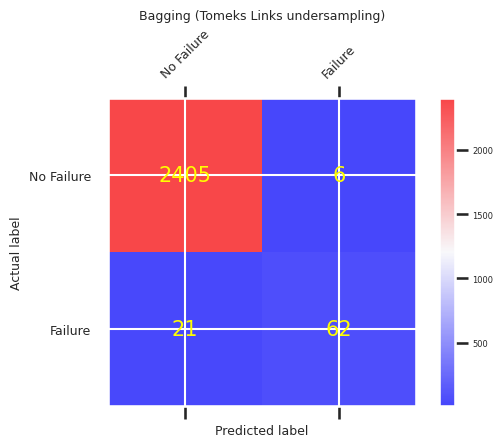

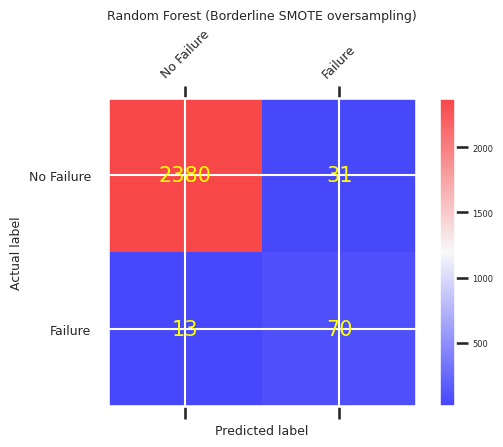

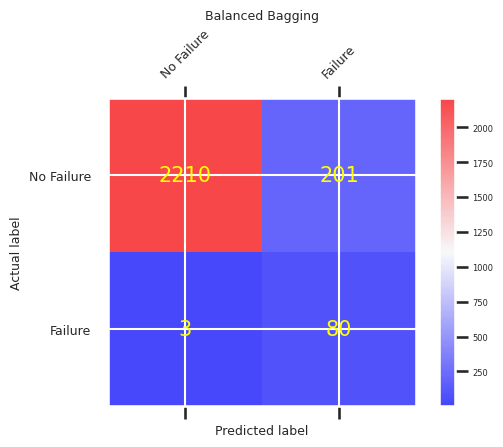

In [52]:
j=0
titles = [
    'Bagging (Tomeks Links undersampling)',
    'Random Forest (Borderline SMOTE oversampling)',
    'Balanced Bagging'
]
for model in [bag_model, rf_model, bal_bag_model]:
    y_pred = model.predict(X_test)
    # Confusion matrix test data
    cm = confusion_matrix(y_test, y_pred)
    plotConfusionMatrix(cm,titles[j],['No Failure', 'Failure'])
    j += 1

- The current bagging tomek links model does a better job at classifying overall. However, the recall score is low. Consequently, it missed a lot failures.
- The current balanced bagging has a much higher recall; hence it is able to predict almost every failure. However, it has many false positives.

So, what to do next? We can check the roc-auc and precision-recall curves and play around with the decision threshold

## Roc and precision-recall curves


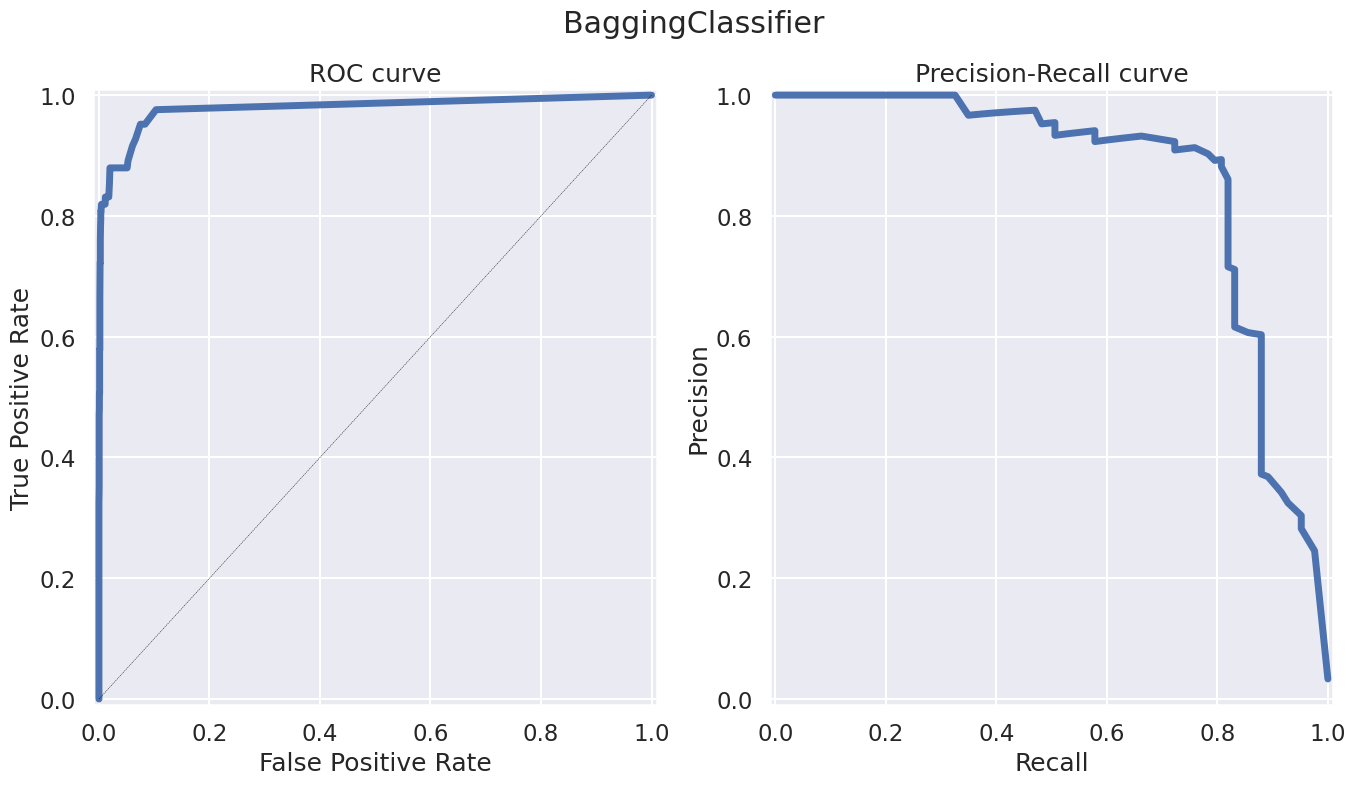

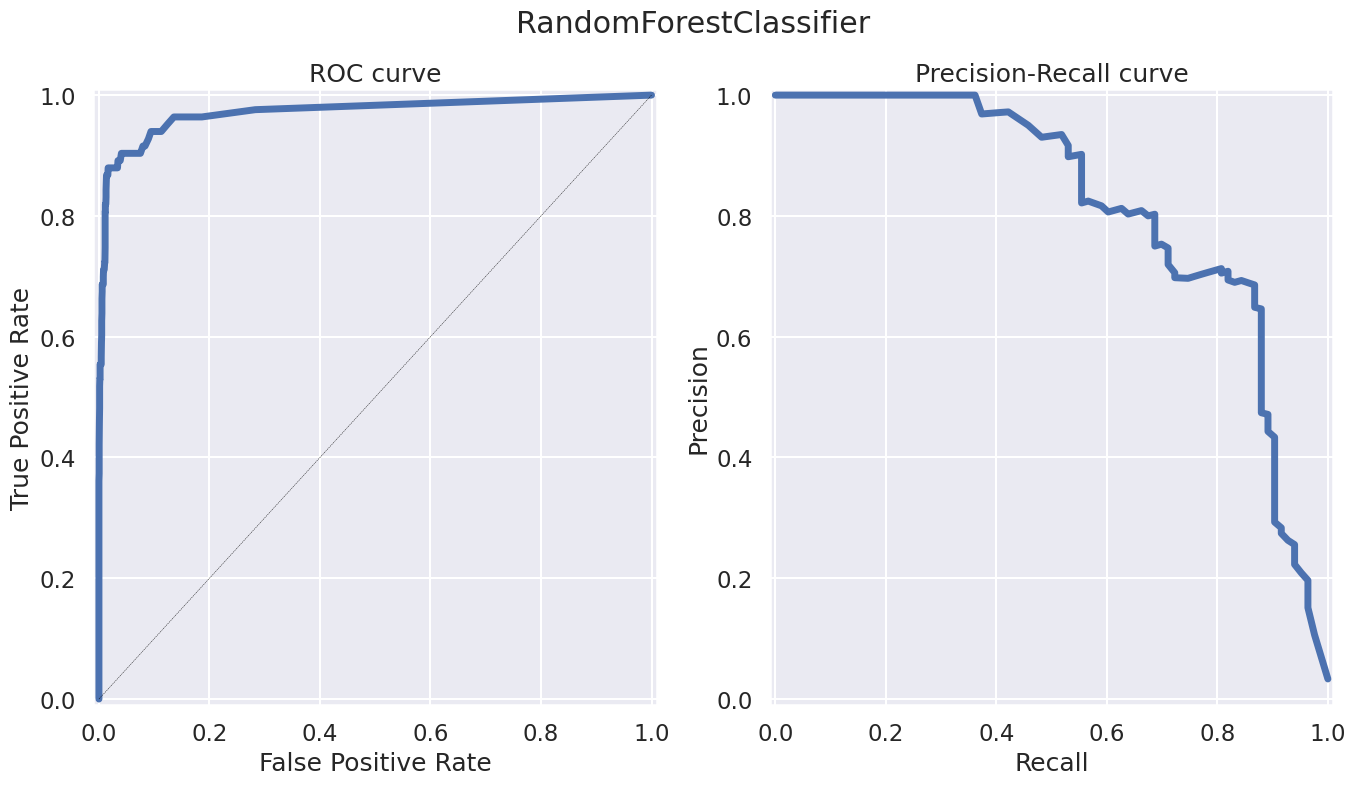

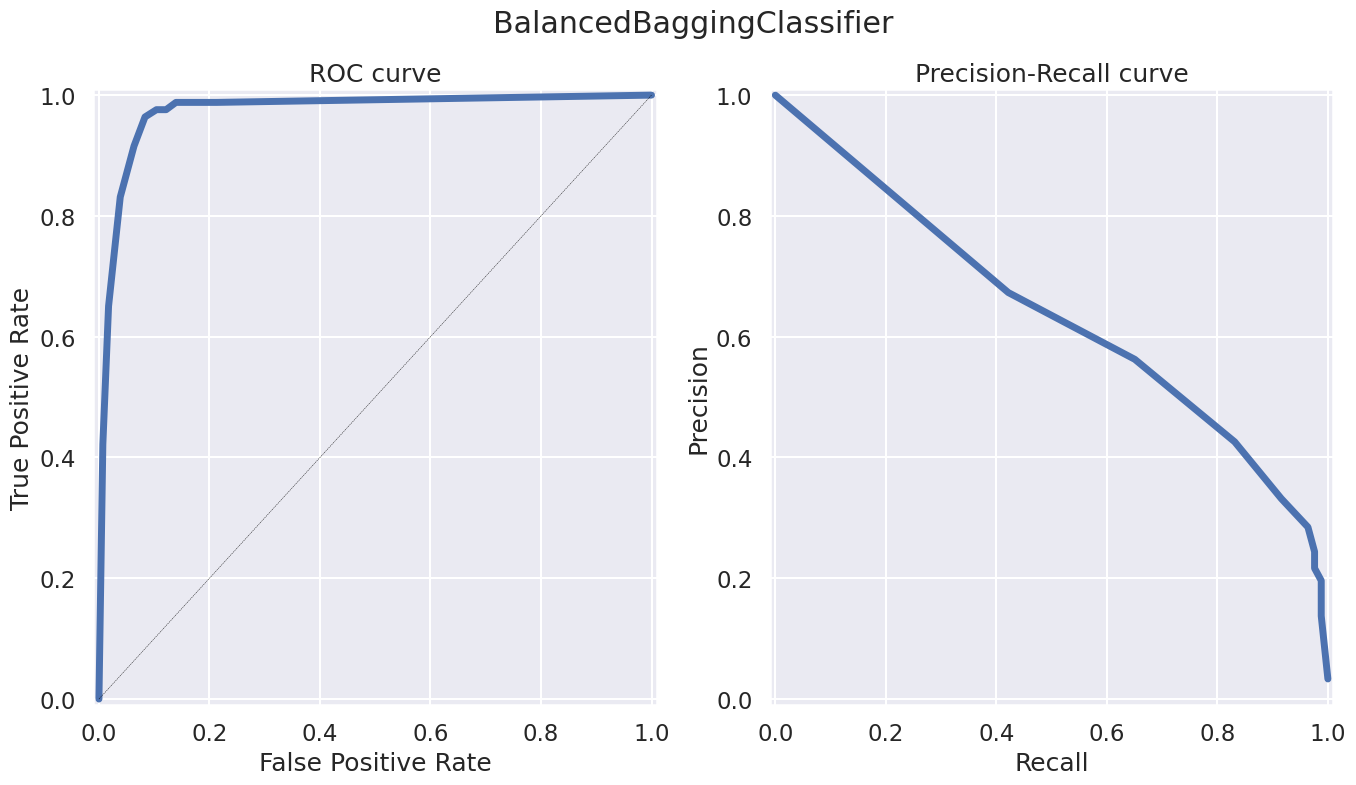

In [53]:
# Roc curve
def roc_prec_recall_curves(model):
    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(16, 8)

    y_prob = model.predict_proba(X_test)

    # ROC-AUC curve
    ax = axList[0]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
    ax.plot(fpr, tpr, linewidth=5)
    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='ROC curve')
    ax.grid(True)

    # Precision-recall curve
    ax = axList[1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
    ax.plot(recall, precision, linewidth=5)
    ax.set(xlabel='Recall', ylabel='Precision',
           xlim=[-.01, 1.01], ylim=[-.01, 1.01],
           title='Precision-Recall curve')
    ax.grid(True)
    plt.suptitle(str(model).split('(')[0])
    
roc_prec_recall_curves(bag_model)
roc_prec_recall_curves(rf_model)
roc_prec_recall_curves(bal_bag_model)
plt.show()

Those plots are using a decision threshold of 0.5 when classiying. As mentioned before, we can play with this number to get a higher recall or precision, considering that there is always a trade-off between them. Let's do that:

## Precision-Recall wrt decision threshold

First, let's check the classification report of the bagigng tomek links model once again:

In [54]:
# Classification report
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2411
           1       0.91      0.75      0.82        83

    accuracy                           0.99      2494
   macro avg       0.95      0.87      0.91      2494
weighted avg       0.99      0.99      0.99      2494



With this model, for the minority class (failure) we obtain a recall of 0.75 and a precision of 0.91. The algorithm classifies using a threshold of 0.5, meaning that if the probability of a certain instance of being class 1 (failure) is 0.51, it will be classied as failure. On the other hand, if it is less than 0.5 it will be classify as not failure.

We can change this threshold to obtain higher recall or precision scores, depending on what we are trying to achieve. For instace, setting a decision threshold at 0.6 would decrease recall and increase precision, and viceversa.

In the curves below, we can see the trade off between recall and precision (for failure class) by changing the decision threshold.

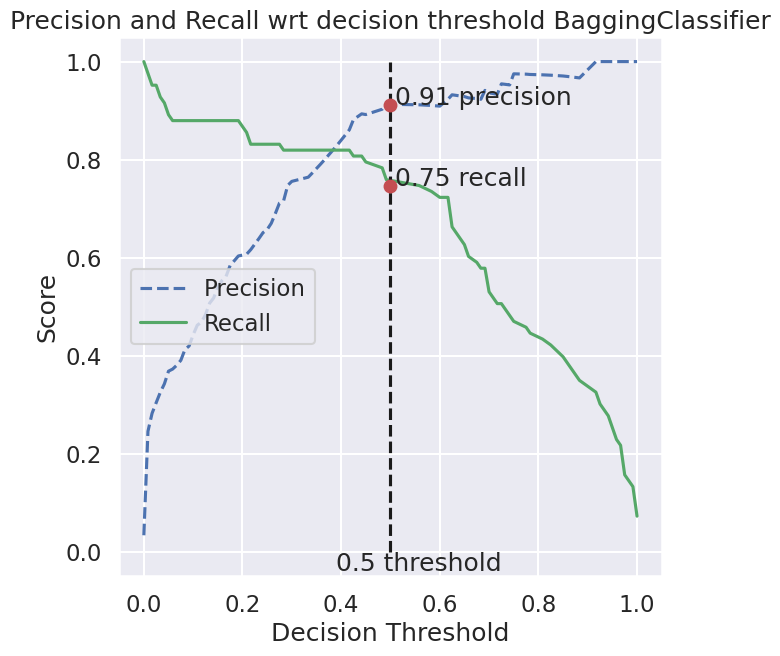

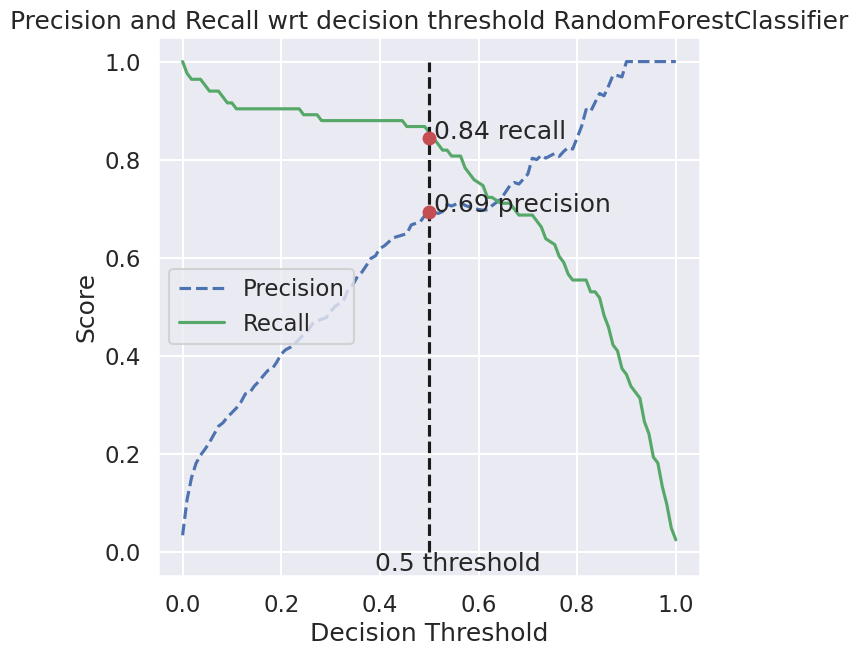

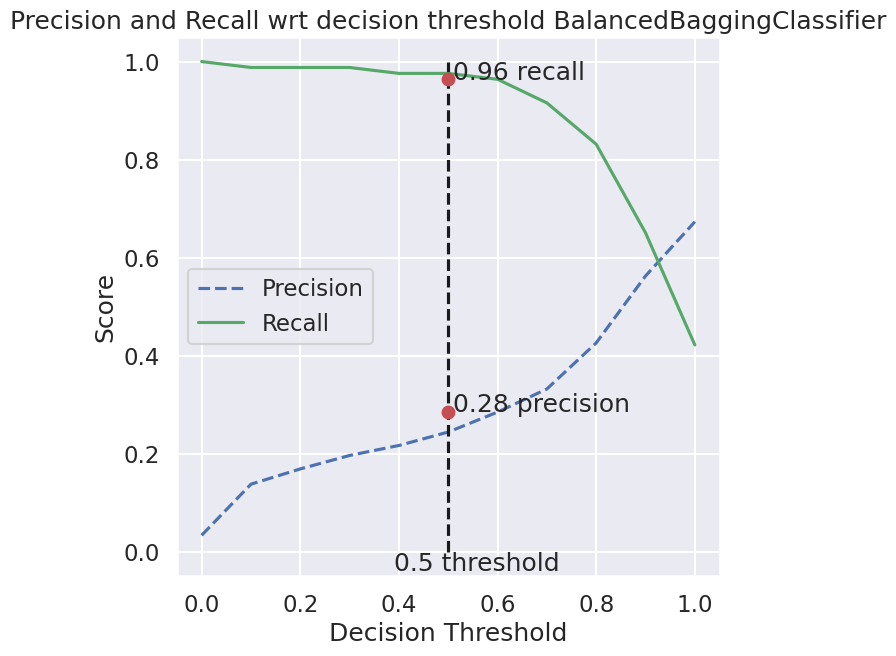

In [55]:
def plot_precision_recall_threshold(model):
    y_pred = model.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred)
    
    plt.figure(figsize=(7, 7))
    plt.title("Precision and Recall wrt decision threshold " + str(model).split('(')[0])
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot([0.5, 0.5], [0, 1], 'k--')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='center left')
    
    y_pred = model.predict(X_test)
    metrics = precision_recall_fscore_support(y_test, y_pred)
    precision = metrics[0][1]
    recall = metrics[1][1]
    
    # Precision score at 0.5 threshold
    plt.plot(0.5, precision, 'or')
    plt.annotate(f'{precision:.2f} precision', (0.51, precision))
    # Recall score at 0.5 threshold
    plt.plot(0.5, recall, 'or')
    plt.annotate(f'{recall:.2f} recall', (0.51, recall))
    plt.annotate('0.5 threshold', (0.39, -0.04))

plot_precision_recall_threshold(bag_model)
plot_precision_recall_threshold(rf_model)
plot_precision_recall_threshold(bal_bag_model)

plt.show()

- In the bagging tomeks links moel, with a default 0.5 threshold, we obtain a 0.75 recall and 0.91 precision score, just as seen in the classification report above. 
- In the Balanced Bagging, with a 0.5 decision threshold, we obtain a much higher recall (0.96), but lower precision (0.28).


We can move the decision threshold to achieve the desired trade-off of precision-recall. Since we are trying to predict machine failure, the minority class (class failure) should be more important. Hence, we aim at higher recall at the expense of lower precision. In my opinion, it is better to have some false positives than not predict a failure.

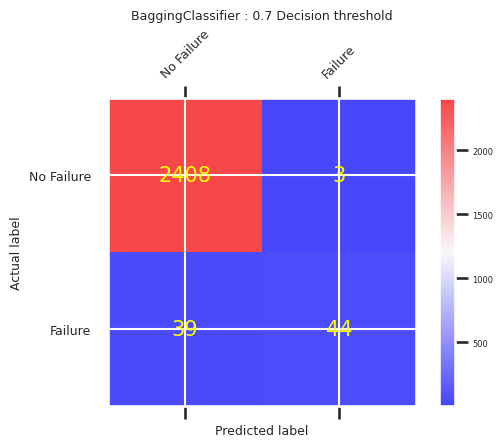

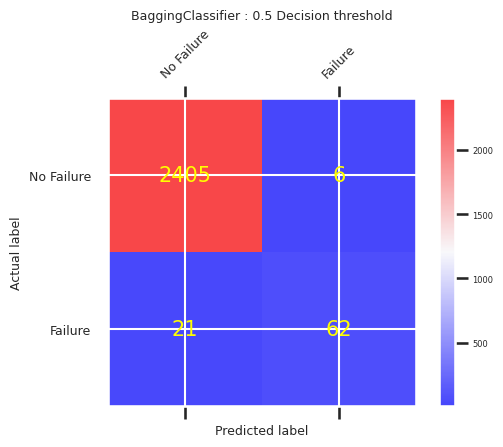

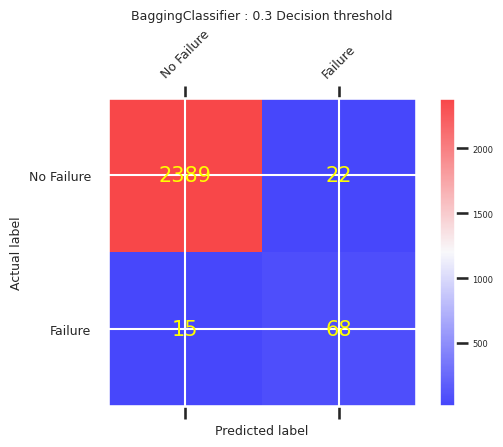

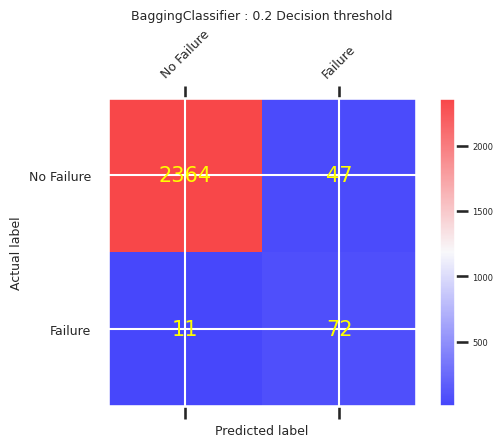

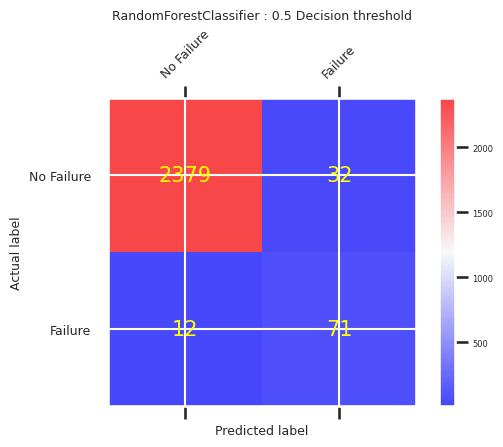

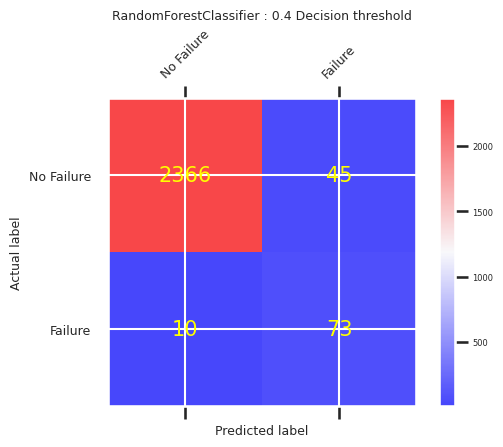

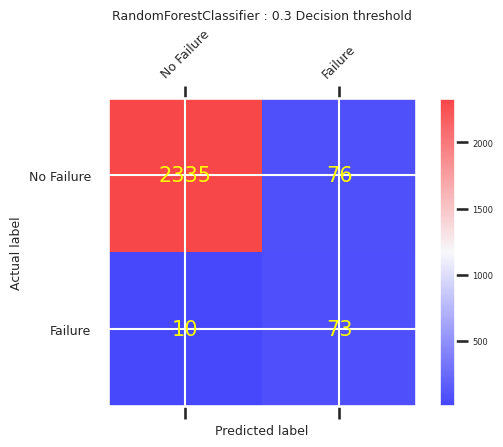

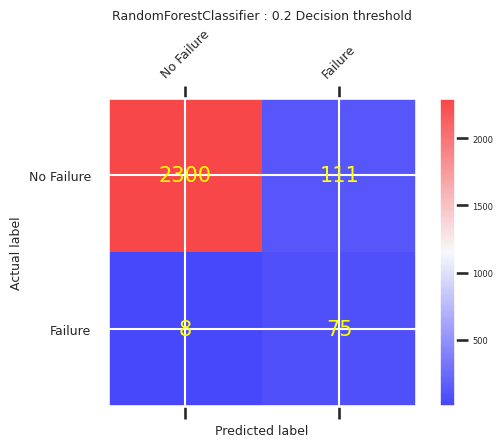

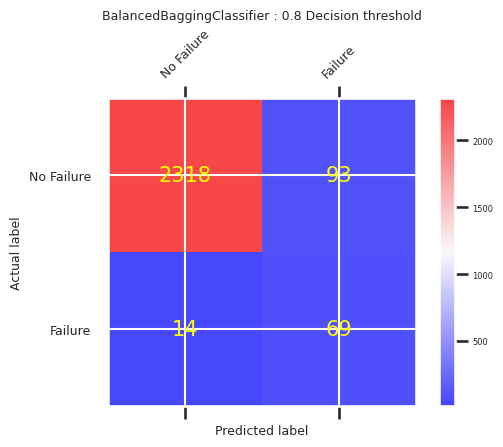

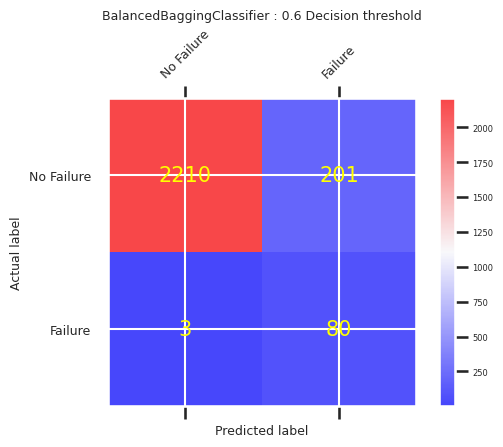

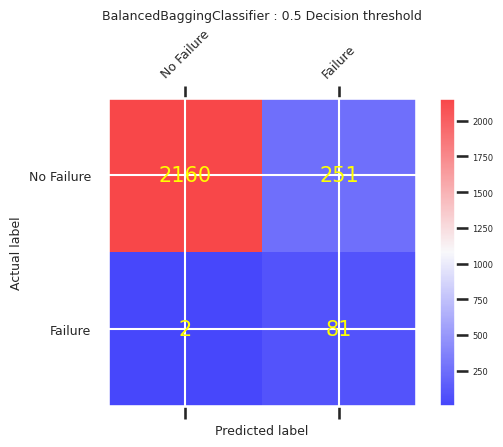

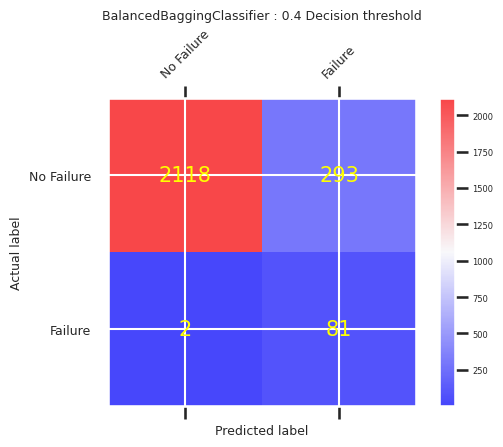

In [56]:
def confusion_matrix_threshold(model, threshold:list):
    # Prediction probabilities with different thresholds
    y_pred_dt_0 = (model.predict_proba(X_test)[:,1] >= threshold[0]).astype(bool).astype(int)
    y_pred_dt_1 = (model.predict_proba(X_test)[:,1] >= threshold[1]).astype(bool).astype(int)
    y_pred_dt_2 = (model.predict_proba(X_test)[:,1] >= threshold[2]).astype(bool).astype(int)
    y_pred_dt_3 = (model.predict_proba(X_test)[:,1] >= threshold[3]).astype(bool).astype(int)
    y_pred_dt_4 = (model.predict_proba(X_test)[:,1] >= threshold[4]).astype(bool).astype(int)
    
    # Confusion matrices with different thresholds
    cm_dict = {}
    cm_dict['cm_dt_0'] = confusion_matrix(y_test, y_pred_dt_0)
    cm_dict['cm_dt_1'] = confusion_matrix(y_test, y_pred_dt_1)
    cm_dict['cm_dt_2'] = confusion_matrix(y_test, y_pred_dt_2)
    cm_dict['cm_dt_3'] = confusion_matrix(y_test, y_pred_dt_3)
    cm_dict['cm_dt_4'] = confusion_matrix(y_test, y_pred_dt_4)

    # Plotting confusion matrices
    for n in range(0,4):
        plotConfusionMatrix(cm_dict[f'cm_dt_{n}'],str(model).split('(')[0]+f' : {threshold[n]} Decision threshold',['No Failure', 'Failure'])

confusion_matrix_threshold(bag_model, [0.7, 0.5, 0.3, 0.2, 0.01])
confusion_matrix_threshold(rf_model, [0.5, 0.4, 0.3, 0.2, 0.01])
confusion_matrix_threshold(bal_bag_model, [0.8, 0.6, 0.5, 0.4, 0.3])

# Conclusions

In my opinion, the experts from the maintenance and manufacturing departments should be the ones who choose the model in accordance with their objectives.
- If they are looking for the highest failure detection possible, they should go with the balanced bagging model, thou they would be sacrificing precision with lots of false positives. 
- If they want a balance between precision and recall, perhaps they could choose between the bagging model 0.4 decision threshold or the random forest model with 0.5  threshold. 
- Maybe they do not care much about predicting every failure, but when they do, they want the highest precision possible. In that case, it would be better to opt for the bagging tomek links classifier with a bit higher decision threshold. 

So, the selection of the model depends on the application and desired outcomes.


# Saving Models

In [57]:
with open("../models/supervised_Bagging_binary.pkl","wb") as files:
    pickle.dump(bag_model,files)
with open("../models/supervised_RandomForest_binary.pkl","wb") as files:
    pickle.dump(rf_model,files)
with open("../models/supervised_BalancedBagging_binary.pkl","wb") as files:
    pickle.dump(bal_bag_model,files)

#  Modeling with 'Failure Type' target

Now, let's treat the problem as a multiclass one.

##  Stratified Split

In [58]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Failure Type'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
Failure Type
0.0    0.966911
4.0    0.011230
1.0    0.009526
3.0    0.007821
2.0    0.004512
Name: proportion, dtype: float64
Target proportion in y_train dataset:
Failure Type
0.0    0.966974
4.0    0.011231
1.0    0.009493
3.0    0.007755
2.0    0.004546
Name: proportion, dtype: float64
Target proportion in y_test dataset:
Failure Type
0.0    0.966720
4.0    0.011227
1.0    0.009623
3.0    0.008019
2.0    0.004411
Name: proportion, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

## Balanced Models

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)


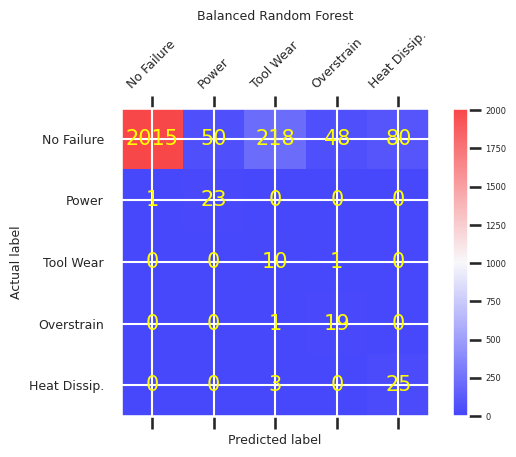

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)


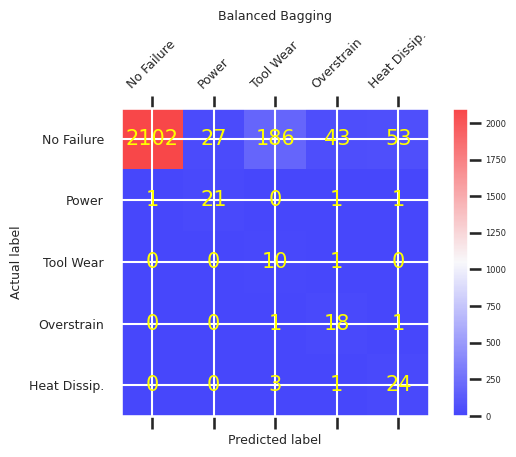

Fitting RUSBoostClassifier(random_state=42)


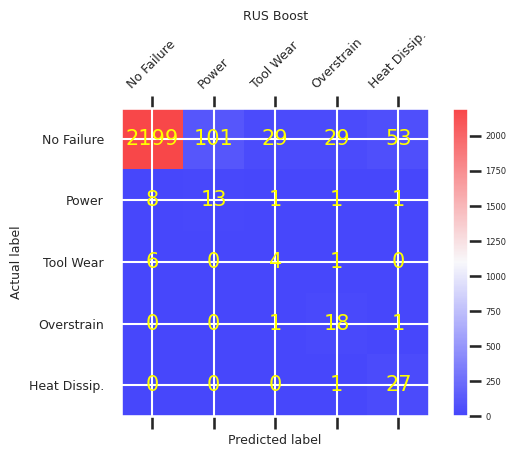

Fitting EasyEnsembleClassifier(random_state=42)


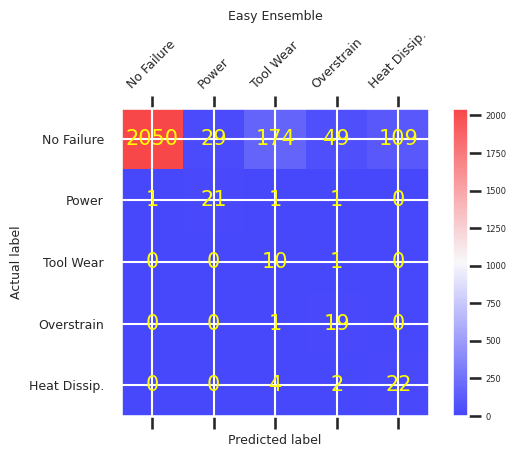

In [59]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

i=0
j=0
titles = [
    'Balanced Random Forest',
    'Balanced Bagging',
    'RUS Boost',
    'Easy Ensemble'
]

columns = ['No Failure', 'Power', 'Tool Wear', 'Overstrain', 'Heat Dissip.']
for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
    
    y_pred = model.predict(X_test)
    y_preb_probs = model.predict_proba(X_test)
    y_test
    cm = confusion_matrix(y_test, y_pred)
    plotConfusionMatrix(cm,titles[j],columns)
    j += 1

Again, Balanced Random Forest and Balanced Bagging outpeformed the other two algorithms.

##  Balanced Random Forest (Random Search)

In [60]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': np.arange(150, 400, 50),
               'max_depth': np.arange(10, 50, 10),
               'min_samples_split': [2, 4, 6],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': ['sqrt', 'log2']
            }

random_search = RandomizedSearchCV(brfc, params, cv=3,
                                 n_iter=100, random_state=42, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

# Best parameters from random search
print(random_search.best_params_)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


## Balanced Random Forest (Grid Search)

In [61]:
import logging
## Set log level to error
# Set the logging level to ERROR
logging.basicConfig(level=logging.ERROR)

brfc = BalancedRandomForestClassifier(max_features='sqrt', random_state=42, n_jobs=-1)

params = {'n_estimators': [40, 50, 60],
               'max_depth': [15, 20, 25],
               'min_samples_leaf': [1, 2]
            }

grid_search = GridSearchCV(brfc, params, cv=cv,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)
# Best parameters from grid search
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 40}

## Training both models with the best hyperparameters

In [62]:
# Balanced Random Forest
brfc = BalancedRandomForestClassifier(n_estimators=40, max_depth=15, min_samples_leaf=1,
                                     max_features='sqrt', random_state=42, n_jobs=-1)

brfc = brfc.fit(X_train, y_train)
y_pred_brfc = brfc.predict(X_test)
y_pred_probs_brfc = brfc.predict_proba(X_test)

# Balanced Bagging
bbc = BalancedBaggingClassifier(n_estimators=13, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred_bbc = bbc.predict(X_test)
y_pred_probs_bbc = bbc.predict_proba(X_test)

## Scores

In [63]:
# Balanced Random Forest scores
print('Results for Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('='*53)
print()

# Balanced Bagging scores
print('Results for Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))

Results for Balanced Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2411
         1.0       0.36      1.00      0.53        24
         2.0       0.04      0.91      0.08        11
         3.0       0.24      0.95      0.38        20
         4.0       0.24      0.79      0.36        28

    accuracy                           0.84      2494
   macro avg       0.38      0.90      0.45      2494
weighted avg       0.97      0.84      0.90      2494


Results for Balanced Bagging
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      2411
         1.0       0.47      0.96      0.63        24
         2.0       0.05      0.91      0.09        11
         3.0       0.31      0.90      0.46        20
         4.0       0.28      0.82      0.41        28

    accuracy                           0.87      2494
   macro avg       0.42      0.89      0.51      2494
weighted avg

## Confusion matrix

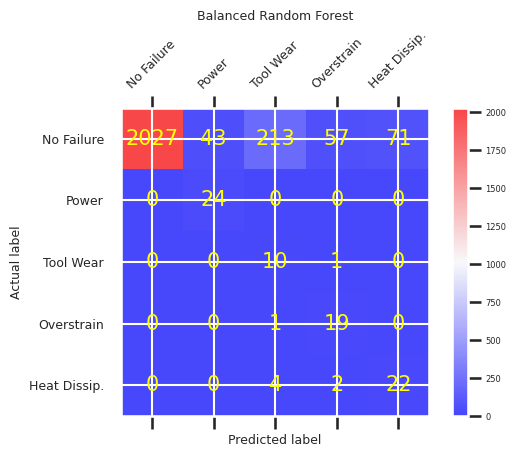

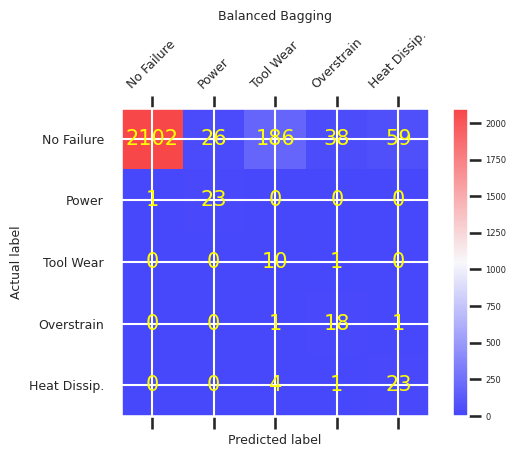

In [64]:
columns = ['No Failure', 'Power', 'Tool Wear', 'Overstrain', 'Heat Dissip.']
cm_brfc = confusion_matrix(y_test, y_pred_brfc)
plotConfusionMatrix(cm_brfc,'Balanced Random Forest',columns)
cm_bbc = confusion_matrix(y_test, y_pred_bbc)
plotConfusionMatrix(cm_bbc,'Balanced Bagging',columns)

##  Save Model

In [65]:
with open("../models/supervised_BalBagging_multiclass.pkl","wb") as files:
    pickle.dump(bbc,files)
with open("../models/supervised_BalRandomForest_multiclass.pkl","wb") as files:
    pickle.dump(brfc,files)